## Aims and Dataset:

I used a publicly available (Kaggle) data sets with both conventional and strokes gained PGA TOUR data, pulling from seasons occuring between 2010 and 2018. Here are links: 
https://www.kaggle.com/datasets/jmpark746/pga-tour-data-2010-2018/data

Some seasons are missing (eg Rory Mcillroy's 2010-2018 seasons are all present except 2015 in the first data set) and so I ended up with 1674 player seasons.

My hypotheses are something like the following: 
* Given strokes gained total and some menagerie of conventional statistics, we can accurately estimate strokes gained by phase of the game. I should note that every statistic here is a season-long average.

* Estimates in the 'off the tee' and 'around the green' categories will be most accurate; I think strokes gained: off the tee should be well-estimated using driving distance, and fairway %, while scrambling % will be predictive of strokes gained: around the green.

I care about these goals because I have hopes of extrapolating strokes gained-like analysis to 
* professional tournaments and eras where strokes gained data is unavailable
* players, both recreational and competitive, who want to estimate their strokes-gained data without intensive data collection.

While it may seem odd to use 'strokes gained: total' as a predictor in a project about predicting strokes gained data with conventional statistics, the key distinction is that strokes gained: total requires only the scores of everyone in a tournament, along with some sense of strength of field, both of which can be calculated going way, way back. It is really just a weighted score for the round. On the other hand, stats like strokes gained: putting require knowing where each putt occured and how many strokes are expected from each distance, thus requiring much more robust data collection. 

I'll try to see if some standard supervised machine learning techniques, namely linear , lasso, and ridge regressions, along with SVR, can be used to predict the strokes gained data from the conventional data.

Depending on how that goes, I'll try to do some exploratory analysis predicting strokes gained data in situations where it wasn't available. 

## Analysis

### Importing, Cleaning, and Scaling Data

In [104]:
#basic packages and taking a look at the data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, make_scorer

pga=pd.read_csv(r"C:\Users\natha\OneDrive\Documents\ML_portfolio\strokes_gained_from_basic_stats\pgaTourData.csv")
#pga_data.head()
pga.info()
pga.shape
pga.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2312 entries, 0 to 2311
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Player Name         2312 non-null   object 
 1   Rounds              1678 non-null   float64
 2   Fairway Percentage  1678 non-null   float64
 3   Year                2312 non-null   int64  
 4   Avg Distance        1678 non-null   float64
 5   gir                 1678 non-null   float64
 6   Average Putts       1678 non-null   float64
 7   Average Scrambling  1678 non-null   float64
 8   Average Score       1678 non-null   float64
 9   Points              2296 non-null   object 
 10  Wins                293 non-null    float64
 11  Top 10              1458 non-null   float64
 12  Average SG Putts    1678 non-null   float64
 13  Average SG Total    1678 non-null   float64
 14  SG:OTT              1678 non-null   float64
 15  SG:APR              1678 non-null   float64
 16  SG:ARG

,Rounds,Fairway Percentage,Year,Avg Distance,gir,Average Putts,Average Scrambling,Average Score,Wins,Top 10,Average SG Putts,Average SG Total,SG:OTT,SG:APR,SG:ARG
count,1678.000000,1678.000000,2312.000000,1678.000000,1678.000000,1678.000000,1678.000000,1678.000000,293.000000,1458.000000,1678.000000,1678.000000,1678.000000,1678.000000,1678.000000
mean,78.711561,61.440560,2013.996107,290.807688,65.661675,29.163331,58.115638,70.921961,1.218430,2.781893,0.025641,0.148105,0.037759,0.065015,0.019974
std,14.274137,5.058845,2.581176,8.916631,2.745411,0.518468,3.384769,0.698305,0.573443,1.895094,0.343787,0.694923,0.379892,0.380952,0.223361
min,45.000000,43.020000,2010.000000,266.400000,53.540000,27.510000,44.010000,68.698000,1.000000,1.000000,-1.475000,-3.209000,-1.717000,-1.680000,-0.930000
25%,69.000000,57.942500,2012.000000,284.900000,63.830000,28.810000,55.900000,70.494250,1.000000,1.000000,-0.187000,-0.254750,-0.190250,-0.180750,-0.123000
50%,79.500000,61.430000,2014.000000,290.550000,65.790000,29.140000,58.275000,70.902000,1.000000,2.000000,0.040000,0.147000,0.056000,0.081000,0.022000
75%,89.000000,64.910000,2016.000000,296.400000,67.580000,29.520000,60.420000,71.342750,1.000000,4.000000,0.257000,0.568500,0.291500,0.314500,0.175000
max,120.000000,76.880000,2018.000000,319.700000,73.520000,31.000000,69.330000,74.400000,5.000000,14.000000,1.130000,2.406000,1.485000,1.533000,0.660000


In [105]:
min(pga['Rounds'])
pga[pga['Player Name'].str.contains('Rory M')]

,Player Name,Rounds,Fairway Percentage,Year,Avg Distance,gir,Average Putts,Average Scrambling,Average Score,Points,Wins,Top 10,Average SG Putts,Average SG Total,SG:OTT,SG:APR,SG:ARG,Money
162,Rory McIlroy,64.0,55.79,2018,319.7,66.30,28.46,62.97,69.303,"1,154",1.0,5.0,0.060,1.412,0.761,0.269,0.322,"$4,410,296"
350,Rory McIlroy,51.0,54.97,2017,316.7,65.94,28.65,63.12,69.529,803,NaN,6.0,-0.304,1.212,0.965,0.322,0.095,"$2,430,182"
459,Rory McIlroy,69.0,61.06,2016,306.8,69.62,29.18,58.70,69.646,973,NaN,6.0,-0.207,1.681,1.230,0.447,0.211,"$5,790,585"
861,Rory McIlroy,66.0,59.93,2014,310.5,69.44,28.59,58.52,68.827,"2,582",3.0,9.0,0.274,2.266,1.367,0.602,0.022,"$8,280,096"
1068,Rory McIlroy,56.0,57.92,2013,302.2,65.45,28.85,54.68,70.288,777,NaN,5.0,-0.093,0.985,0.624,0.420,0.032,"$1,802,443"
1264,Rory McIlroy,60.0,56.61,2012,310.1,66.36,28.72,60.24,68.873,"2,092",2.0,7.0,0.058,2.406,1.072,1.002,0.273,"$8,047,952"
1600,Rory McIlroy,54.0,62.64,2010,300.0,66.24,29.27,60.13,70.351,"1,101",1.0,5.0,-0.225,0.714,0.698,0.271,-0.025,"2,554,280"
1872,Rory McIlroy,NaN,NaN,2015,NaN,NaN,NaN,NaN,NaN,"1,567",2.0,6.0,NaN,NaN,NaN,NaN,NaN,"$4,863,312"


So as a first note, only 1678 of our 2300 player seasons have data beyond the bare bones points/money/year categories, and I am pretty sure that's due to a minimum round cutoff applied by the pgatour when tabulating averages for each season. The exact number for the cutoff I am unsure of because "measured rounds" appears differently for players on different parts of the website, but at least in our data set, every player with season long data played at least 45 rounds. We'll get rid of all the seasons without season long statistics. It turns out there are also 4 rogue seasons with no points or money, I'll just remove those ones as well.

In [106]:
pga=pga.dropna(subset=['Rounds','Points','Money'])
pga.head()

,Player Name,Rounds,Fairway Percentage,Year,Avg Distance,gir,Average Putts,Average Scrambling,Average Score,Points,Wins,Top 10,Average SG Putts,Average SG Total,SG:OTT,SG:APR,SG:ARG,Money
0,Henrik Stenson,60.0,75.19,2018,291.5,73.51,29.93,60.67,69.617,868,NaN,5.0,-0.207,1.153,0.427,0.960,-0.027,"$2,680,487"
1,Ryan Armour,109.0,73.58,2018,283.5,68.22,29.31,60.13,70.758,"1,006",1.0,3.0,-0.058,0.337,-0.012,0.213,0.194,"$2,485,203"
2,Chez Reavie,93.0,72.24,2018,286.5,68.67,29.12,62.27,70.432,"1,020",NaN,3.0,0.192,0.674,0.183,0.437,-0.137,"$2,700,018"
3,Ryan Moore,78.0,71.94,2018,289.2,68.80,29.17,64.16,70.015,795,NaN,5.0,-0.271,0.941,0.406,0.532,0.273,"$1,986,608"
4,Brian Stuard,103.0,71.44,2018,278.9,67.12,29.11,59.23,71.038,421,NaN,3.0,0.164,0.062,-0.227,0.099,0.026,"$1,089,763"


Now we need to do a little more cleaning, first taking the NaN values in the Wins and Top 10 categories and turning them into 0's, then turning the Money and Points column into floats. I also want to add a column, strokes gained tee to green, which captures everything but putting. 

In [107]:
pga['Top 10'].fillna(0, inplace=True)
pga['Top 10'] = pga['Top 10'].astype(int)
pga['Wins'].fillna(0, inplace=True)
pga['Wins'] = pga['Wins'].astype(int)
def str_to_flt(st):
        st=st.replace('$','')
        st=st.replace(',', '')
        return float(st)
pga['Points']=pga['Points'].apply(str_to_flt)
pga['Money']=pga['Money'].apply(str_to_flt)
pga.rename(columns={'Average SG Putts': 'SG:PUTT', 'Average SG Total':'SG:TOTAL'},inplace=True)
pga['SG:TTG']=pga['SG:TOTAL']-pga['SG:PUTT']
pga['SG:LONG']=pga['SG:TOTAL']-(pga['SG:PUTT']+pga['SG:ARG'])
pga.info()
pga.isna().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1674 entries, 0 to 1677
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Player Name         1674 non-null   object 
 1   Rounds              1674 non-null   float64
 2   Fairway Percentage  1674 non-null   float64
 3   Year                1674 non-null   int64  
 4   Avg Distance        1674 non-null   float64
 5   gir                 1674 non-null   float64
 6   Average Putts       1674 non-null   float64
 7   Average Scrambling  1674 non-null   float64
 8   Average Score       1674 non-null   float64
 9   Points              1674 non-null   float64
 10  Wins                1674 non-null   int32  
 11  Top 10              1674 non-null   int32  
 12  SG:PUTT             1674 non-null   float64
 13  SG:TOTAL            1674 non-null   float64
 14  SG:OTT              1674 non-null   float64
 15  SG:APR              1674 non-null   float64
 16  SG:ARG

Player Name           0
Rounds                0
Fairway Percentage    0
Year                  0
Avg Distance          0
gir                   0
Average Putts         0
Average Scrambling    0
Average Score         0
Points                0
Wins                  0
Top 10                0
SG:PUTT               0
SG:TOTAL              0
SG:OTT                0
SG:APR                0
SG:ARG                0
Money                 0
SG:TTG                0
SG:LONG               0
dtype: int64

Next, I'll scale the data before we start running some regressions. I want to focus on the on course statistics so I'll also drop stuff like points, wins, top 10's etc....

In [151]:
nonvars=['Player Name', 'Year', 'Points', 'Wins', 'Top 10', 'Money','Rounds']
nonvars2=['Player Name', 'Year']
yvars=['SG:PUTT','SG:OTT', 'SG:APR','SG:ARG','SG:TTG','SG:LONG']
X=pga.drop(nonvars2+yvars,axis=1).values
y=pga[yvars].values
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=.2,random_state=62)
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

### First Pass at Regression
So on some level I am just curious if we can retrieve strokes gained data from all the statistics, but ideally we could arrive at some kind of formula that is relatively intuitive and uses few variables so that it could be put into practice for amateur players. We'll of course try a standard linear regression, but a lasso also makes sense due to my desire for feature selection. While we're trying penalties, may as well do a ridge regression. KNN doesn't make much sense here because it doesn't really tell us about feature selection and won't have much hope of being extrapolated to amateur players (who are 'far' from any of the stats of professional players). Moreover, given that we have multiple player seasons from lots of players, KNN runs the risk of just allowing us to use, say, Phil Mickelson's 2014 and 2016 stats to predict his 2015 ones, which is not really the spirit of the exercise. We could get around this issue with stratified sampling methods and use some kind of constrained clustering but that's beyond the scope of this project.

Last, I'll try an SVR approach because it would be nice to say something not just like, "we can explain 70% of the variance in strokes gained off the tee," (ie an R^2 value) but rather along the lines of, "we have a 90% chance of our predicted strokes gained off the tee for a particular player being within .2 shots." Because really what's fun as a fanalyst type person is being able to paint the players in broad strokes, and so we just want to broadly get things right. Support vector regressions are an extension of the more common SVM approach which is commonly used for classification problems.

First, I will just run a basic linear regression to get a baseline:

In [153]:
def lin_reg_scorer(X,y):
    kf = KFold(n_splits=6, shuffle=True, random_state=65)
    reg=LinearRegression()
    #coeffs=reg.fit(X_train_scaled,y_train).coef_
    
    scoring_dict = {
    'r2': 'r2',
    'rmse': make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)
}
    cv_scores = cross_val_score(reg, X,y, cv=kf)
    cv_scores2= cross_val_score(reg, X,y,cv=kf, scoring=make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False))
    #coeffs=pd.DataFrame(zip(pga_full[xvars].columns, coeffs))
    print("R^2 scores:", cv_scores.mean())
    print("RMSE scores:", -cv_scores2.mean())  


for i in range(len(yvars)):
    print(yvars[i])
    lin_reg_scorer(X_train_scaled,y_train[:,i])
    #coeffs=pd.DataFrame(zip(pga.drop(nonvars+yvars,axis=1).columns, reg.coef_))
    #print(coeffs)

SG:PUTT
R^2 scores: 0.5899471333705945
RMSE scores: 0.22020624576710982
SG:OTT
R^2 scores: 0.7651614116178745
RMSE scores: 0.18227549075642432
SG:APR
R^2 scores: 0.6490649854257555
RMSE scores: 0.22384248342657728
SG:ARG
R^2 scores: 0.4980526576449815
RMSE scores: 0.1593155274989802
SG:TTG
R^2 scores: 0.8807654199282994
RMSE scores: 0.2202062457671099
SG:LONG
R^2 scores: 0.8556340283872732
RMSE scores: 0.23116192736996366


That's fairly strong right out of the gate, in particular the .86 R^2 value for Strokes gained: tee to green, which is sort of a catch-all for ball striking ability. However, after peeking at the coefficients, it seems that strokes gained total is perhaps doing a lot of the predictive work, and so I want to check how well that would do by itself. 

In [154]:
X=pga['SG:TOTAL'].values.reshape(-1, 1)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=.2,random_state=62)
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)
for i in range(len(yvars)):
    print(yvars[i])
    lin_reg_scorer(X_train_scaled,y_train[:,i])

SG:PUTT
R^2 scores: 0.1398585227250081
RMSE scores: 0.31943736035866277
SG:OTT
R^2 scores: 0.2802028969688352
RMSE scores: 0.32130907753406274
SG:APR
R^2 scores: 0.46106404809721296
RMSE scores: 0.2773563610674545
SG:ARG
R^2 scores: 0.16141328832896426
RMSE scores: 0.20595287107748206
SG:TTG
R^2 scores: 0.7475644468422106
RMSE scores: 0.31943736035866277
SG:LONG
R^2 scores: 0.5650787034869232
RMSE scores: 0.401726637335689


And indeed we see that strokes gained: total is quite predictive of strokes gained: TTG and not bad for strokes gained: approach either. These aren't particularly surprising just on the basis that strokes gained: TTG makes up 3 of the 4 categories which sum to strokes gained: total, and moreover SG: approach is known to be dominant among putting, around the green, approach and total in its contribution to strokes SG:total. So it's not surprising the converse also holds. 

I also want to do a sanity check to see how we do when we restrict to just a few intuitive features for each target variable, like average distance and fairway percentage for strokes gained: OTT. 

In [155]:
def lin_reg_scorer2(xvars,yvar):
    X=pga[xvars].values
    y=pga[yvar].values
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=.25,random_state=62)
    scaler=StandardScaler()
    X_train_scaled=scaler.fit_transform(X_train)
    X_test_scaled=scaler.transform(X_test)
    #kf = KFold(n_splits=6, shuffle=True, random_state=65)
    reg=LinearRegression()
    coeffs=reg.fit(X_train_scaled,y_train).coef_
    #cv_scores = cross_val_score(reg, X_train_scaled,y_train, cv=kf)
    coeffs=pd.DataFrame(zip(pga[xvars].columns, coeffs))
    #print (yvar, cv_scores.mean())
    print(yvar)
    print(reg.score(X_train_scaled,y_train))
    print(coeffs)

lin_reg_scorer2(['Avg Distance','Fairway Percentage','SG:TOTAL'],'SG:OTT')
lin_reg_scorer2(['gir','Avg Distance','SG:TOTAL'],'SG:APR')
lin_reg_scorer2(['Average Scrambling','gir','Average Putts','SG:TOTAL'],'SG:ARG')
lin_reg_scorer2(['Average Scrambling','gir','Average Putts','SG:TOTAL'],'SG:PUTT')
lin_reg_scorer2(['Avg Distance','gir','SG:TOTAL'],'SG:LONG')

SG:OTT
0.7459041859346396
                    0         1
0        Avg Distance  0.331388
1  Fairway Percentage  0.240158
2            SG:TOTAL  0.075126
SG:APR
0.5533384459181714
              0         1
0           gir  0.129938
1  Avg Distance -0.042591
2      SG:TOTAL  0.206195
SG:ARG
0.4416301827990766
                    0         1
0  Average Scrambling  0.114447
1                 gir -0.086340
2       Average Putts  0.033226
3            SG:TOTAL  0.082748
SG:PUTT
0.5812060289028934
                    0         1
0  Average Scrambling -0.015065
1                 gir  0.044344
2       Average Putts -0.273922
3            SG:TOTAL  0.048202
SG:LONG
0.7714162444597564
              0         1
0  Avg Distance  0.116787
1           gir  0.260930
2      SG:TOTAL  0.305436


It's notable that with just knowing a guy's overall scoring, average distance off the tee, and greens in regulation percentage, you are roughly 77% of the way there in terms of explaining overall long game ability. Variance in ability off the tee is also nearly 75% explained by just overall scoring, average distance, and fairway percentage. 

The tougher categories to tease out appear to be the short game categories: putting and around the green. That makes sense because the stats we have to measure these are so influenced by the long game shots that come before. For example, a good ball striker will hit lots of greens, leaving lengthy first putts and leading to lots of 2-putts. A bad ball striker will miss greens, chip it close, and have more 1-putts regardless of their overall putting ability. 

Now I'm going to try some more other regression techniques and see if we can improve on the performance of our original linear regression...

### Ridge Regressions

First, I want to get a sense of a reasonable value of the little ell 2 penalty coefficient, alpha. So for each target variable, I'm training a series of models, one for each of a list of possible alpha values and then plotting the performance. I could do this on top of cross-validation to be really careful but that's going to take n times longer, where n is the number of folds, and it's just a little overkill for our purposes here, since the purpose here is just to narrow our range of search for the optimal alpha.

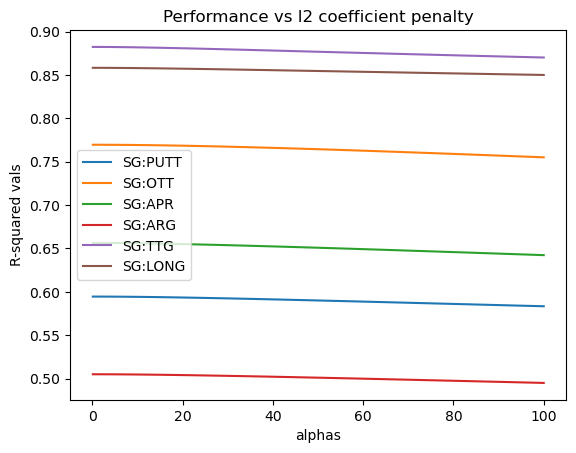

In [157]:
nonvars=['Player Name', 'Year', 'Points', 'Wins', 'Top 10', 'Money','Rounds']
nonvars2=['Player Name', 'Year']
yvars=['SG:PUTT','SG:OTT', 'SG:APR','SG:ARG','SG:TTG','SG:LONG']
X=pga.drop(nonvars+yvars,axis=1).values
y=pga[yvars].values
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=.2,random_state=62)
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)
alphas = np.linspace(.1,100,50)
for i in range(len(yvars)):
    ridge_scores=[]
    for alpha in alphas:
        ridge= Ridge(alpha=alpha)
        ridge.fit(X_train_scaled,y_train[:,i])
        score = ridge.score(X_train_scaled,y_train[:,i])
        ridge_scores.append(score)
    plt.plot(alphas,ridge_scores,label=yvars[i])
    plt.xlabel('alphas')
    plt.ylabel('R-squared vals')
    plt.title('Performance vs l2 coefficient penalty')
    plt.legend()
plt.show()

In [158]:
# Set up the parameter grid
param_grid = {"alpha": np.linspace(.1, 15, 40)}
kf = KFold(n_splits=6, shuffle=True, random_state=62)
for i in range(len(yvars)):
    print(i)
    ridge=Ridge()
    ridge_cv = GridSearchCV(ridge, param_grid, cv=kf)
    ridge_cv.fit(X_train_scaled,y_train[:,i])
    print(yvars[i])
    print("Tuned lasso paramaters: {}".format(ridge_cv.best_params_))
    print("Tuned lasso score: {}".format(ridge_cv.best_score_))

0
SG:PUTT
Tuned lasso paramaters: {'alpha': 3.1564102564102567}
Tuned lasso score: 0.585833290856531
1
SG:OTT
Tuned lasso paramaters: {'alpha': 2.7743589743589747}
Tuned lasso score: 0.7659181457332568
2
SG:APR
Tuned lasso paramaters: {'alpha': 1.6282051282051284}
Tuned lasso score: 0.6480855367436676
3
SG:ARG
Tuned lasso paramaters: {'alpha': 4.302564102564102}
Tuned lasso score: 0.4979539954341519
4
SG:TTG
Tuned lasso paramaters: {'alpha': 0.1}
Tuned lasso score: 0.8795099042600706
5
SG:LONG
Tuned lasso paramaters: {'alpha': 0.1}
Tuned lasso score: 0.8555683612933502


These scores are nearly identical to the original linear regression, so it doesn't appear the lasso is really helping us much here. Just for fun, let's also take a look at the coefficients for a particular alpha (2.3) which looks fairly reasonable from our testing above. 

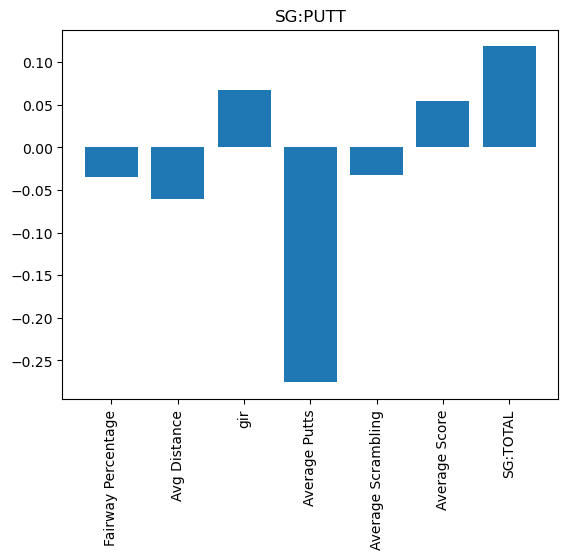

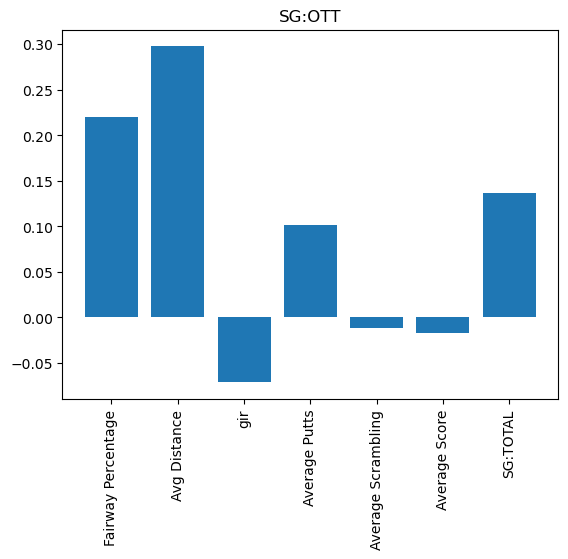

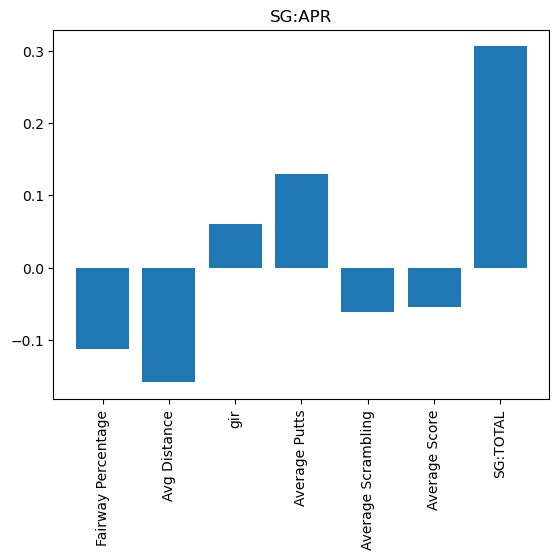

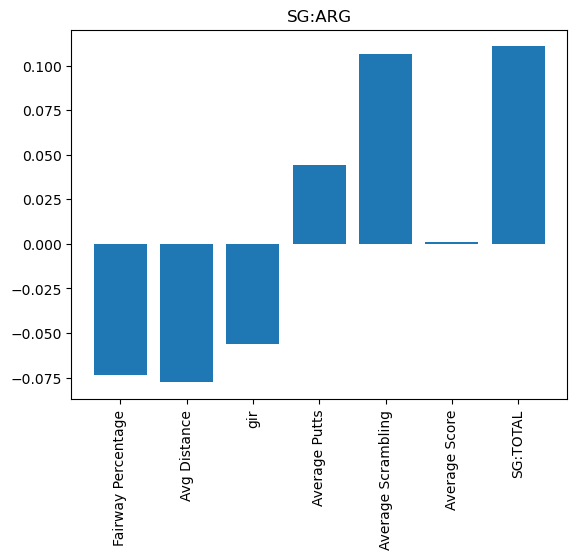

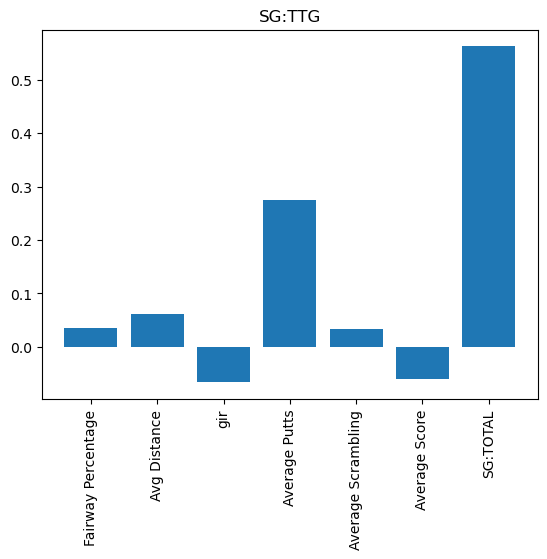

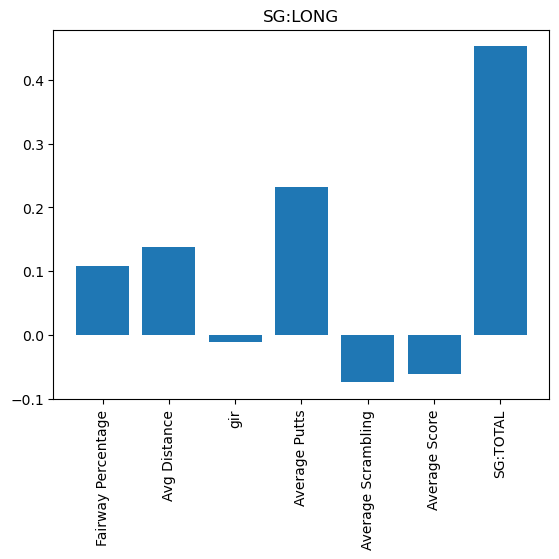

[-3773.7037868918246, -63998.77760658032, -19249.75113582694, -10683.375914554652, -1075.4726389554612, -5213.763195888646]


In [159]:
ridge_scores=[]
for i in range(len(yvars)):
    alpha=.9
    ridge= Ridge(alpha=alpha)
    coeffs=ridge.fit(X_train_scaled,y_train[:,i]).coef_
    score = ridge.score(X_train,y_train[:,i])
    ridge_scores.append(score)
    plt.title(yvars[i])
    plt.bar(pga.drop(nonvars+yvars,axis=1).columns,coeffs)
    plt.xticks(rotation=90)
    plt.show()
print(ridge_scores)

### Lasso Regressions

In [161]:
vif_data = pd.DataFrame() 
vif_data["feature"] = pga.drop(nonvars+yvars,axis=1).columns 
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(X_train_scaled, i) for i in range(len(vif_data['feature']))] 
print(vif_data)

              feature        VIF
0  Fairway Percentage   2.335167
1        Avg Distance   2.565664
2                 gir   4.469700
3       Average Putts   4.183882
4  Average Scrambling   2.270444
5       Average Score  13.883154
6            SG:TOTAL  14.342311


As indicated by the VIF calculation, we have some highly correlated variables and thus, a Lasso makes sense to try. It also makes sense because we'd really like to kill off some features and arrive at formulas that are sensible to the average golfer. 

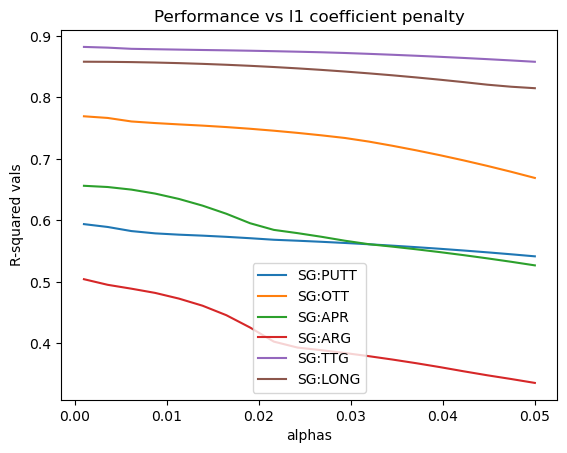

In [162]:

alphas = np.linspace(.001,.05,20)

for i in range(len(yvars)):
    lasso_scores=[]
    for alpha in alphas:
      lasso= Lasso(alpha=alpha)
      lasso.fit(X_train_scaled,y_train[:,i])
      score = lasso.score(X_train_scaled,y_train[:,i])
      lasso_scores.append(score)
    plt.plot(alphas,lasso_scores,label=yvars[i])
    plt.xlabel('alphas')
    plt.ylabel('R-squared vals')
    plt.title('Performance vs l1 coefficient penalty')
    plt.legend()
plt.show()

In [163]:
param_grid = {"alpha": np.linspace(.001, .01, 20)}
kf = KFold(n_splits=6, shuffle=True, random_state=65)
for i in range(len(yvars)):
    print(i)
    lasso=Lasso()
    lasso_cv = GridSearchCV(lasso, param_grid, cv=kf)
    lasso_cv.fit(X_train_scaled,y_train[:,i])
    print(yvars[i])
    print("Tuned lasso paramaters: {}".format(lasso_cv.best_params_))
    print("Tuned lasso score: {}".format(lasso_cv.best_score_))

0
SG:PUTT
Tuned lasso paramaters: {'alpha': 0.001}
Tuned lasso score: 0.58468666316989
1
SG:OTT
Tuned lasso paramaters: {'alpha': 0.001}
Tuned lasso score: 0.7603468310139648
2
SG:APR
Tuned lasso paramaters: {'alpha': 0.001}
Tuned lasso score: 0.6477796283298063
3
SG:ARG
Tuned lasso paramaters: {'alpha': 0.001}
Tuned lasso score: 0.494507213517179
4
SG:TTG
Tuned lasso paramaters: {'alpha': 0.001}
Tuned lasso score: 0.8792656835203906
5
SG:LONG
Tuned lasso paramaters: {'alpha': 0.0014736842105263158}
Tuned lasso score: 0.853461820709496


Ok this was a little dubious due to the lasso just wanting me to choose the smallest possible alpha values, and if i let them get much smaller, than I run into convergence issues when it's trying to compute the coefficients. But we can see that the lasso does do better than the original linear regression. It's worth checking though if an alpha this is small is actually getting rid of any coefficients which is the ostensible point of doing this method. Scoring-wise it's doing almost exactly the same as the previous ridge regression.

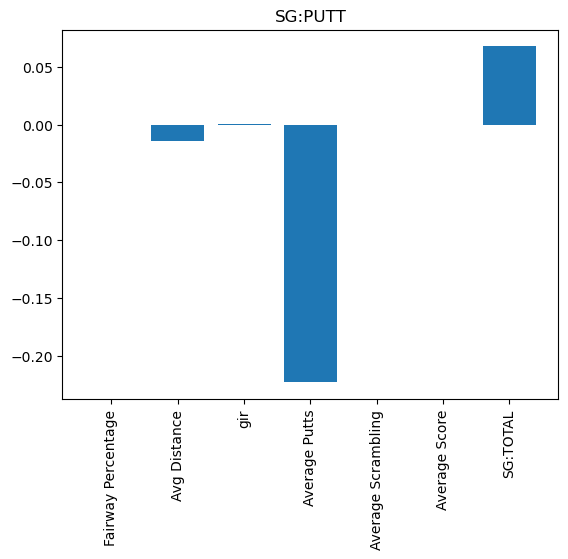

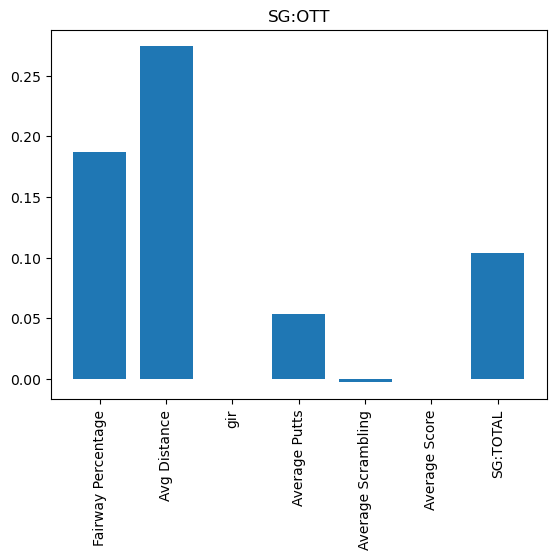

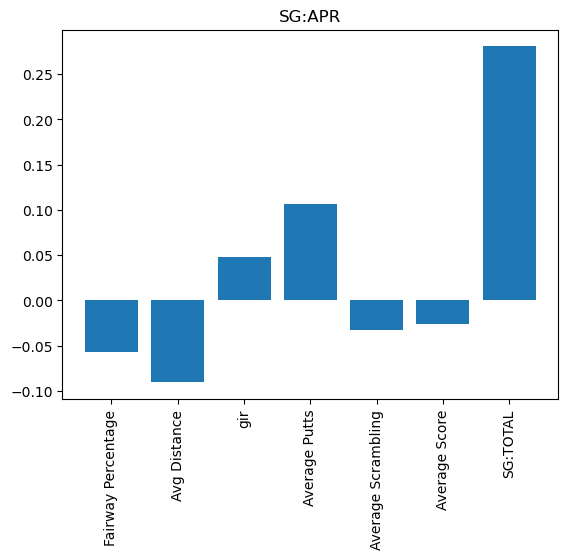

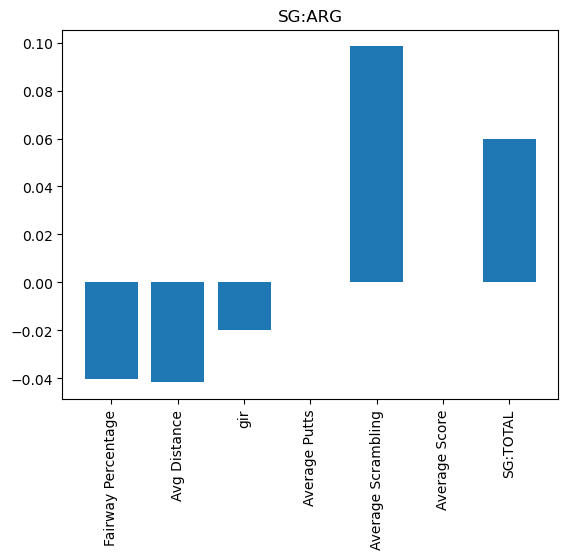

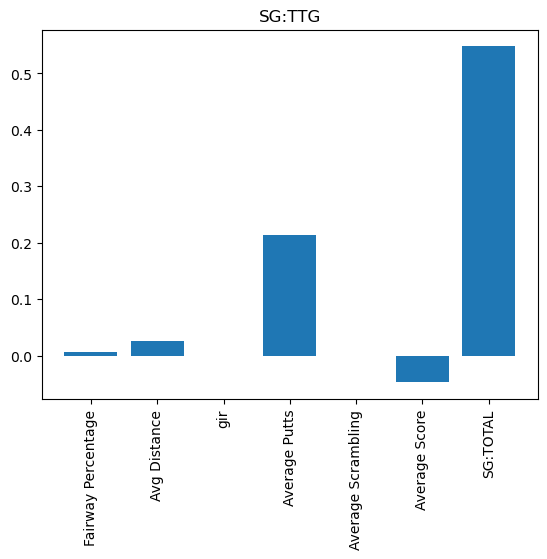

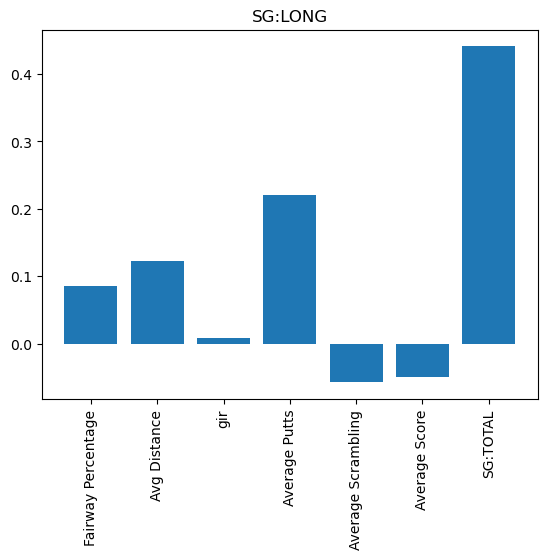

[0.5773721284590339, 0.7572631285290432, 0.6395334191360045, 0.47768511242698697, 0.8780478511827386, 0.856291858874463]


In [167]:
lasso_scores=[]
for i in range(len(yvars)):
    alpha=.01
    lasso= Lasso(alpha=alpha)
    coeffs=lasso.fit(X_train_scaled,y_train[:,i]).coef_
    score = lasso.score(X_train_scaled,y_train[:,i])
    lasso_scores.append(score)
    plt.title(yvars[i])
    plt.bar(pga.drop(nonvars+yvars,axis=1).columns,coeffs)
    plt.xticks(rotation=90)
    plt.show()
print(lasso_scores)

And indeed, basically nothing is being killed off by that tiny alpha=.001 value. If we ramp it to .01, we do start to reduce the support, but not by a huge amount, and we pay a price on the average R^2 values when we do the cross-validation. Some of the coefficients do make sense though. For example, when alpha=.01, we do see fairway % and avg distance, along with SG:TOTAL carry the dominant (and positive!) coefficients. 

### SVR Approach
I'm fairly new to SVR, so here's a primer, mostly for myself.
Support Vector Regression is an extension of the popular support vector machine approach. There are some dubious explanations on the internet, here is an older, much-cited article that I found very helpful:
https://alex.smola.org/papers/2004/SmoSch04.pdf
In the simplest case of SVR, you're looking for a linear predictor Y= <B,x>+ B_0 where you score a predictor (B,B_0) on your training set by a linear combination of 
* the sum of residuals greater than some threshold, epsilon
* the squared ell_2 norm of B

So your two hyper-parameters are the size of the threshold, below which we don't penalize guesses, and the weighting of the penalty of residuals vs the penalty on the squared norm of B. In sklearn, these are the parameters epsilon and C, respectively. As C gets larger, the norm penalty decreases. 

You can tweak this unconstrained optimization problem by adding slack variables to obtain a constrained, convex optimization problem. To solve the resulting problem, you can take a Lagrange multiplier approach, use the KKT conditions, and end up **considering a dual problem which involves a weighted sum of inner products of the input variables**. The dual problem is key because solutions to the dual problem are linear combinations of the input data points, and further analysis shows that computing predictions of the form <B,x>+B_0 **for an optimal B** involves taking inner products of x with various inputs x_i. 

When you want to extend to nonlinear features, of course you can do the standard thing of just preprocessing your data; e.g. if you want quadratic interactions considered, you can just consider new features of the form x_1^2,x_2^2, x_1x_2, etc. and take linear combinations of these new features. But the growth of the number of features gets out of control quickly as the degree of polynomials grows and so doing the optimization to compute an optimal B quickly becomes infeasible. 

Things look hopeless but here's where the machinery saves us: Just as the primal optimization problem in the linear case involves minimizing a weighted sum of inner products of the input variables, **in the nonlinear case, we end up having to minimize a weighted sum of terms K(x_i,x_j)** where K(x_i,x_j) is of the form <Phi(x_i),Phi(x_j)> for some Phi which maps input observations to some tuplet of resulting features, eg. if x_i=(a,b) is in R^2 we could have Phi(x_i)=(a^2,ab,b^2). All of this is to say that the minimizing predictor must be a linear combination of such kernels K, called admissible SV's (support vectors) that can be expressed as inner products of whatever features you're after. And **the number of these K's is much lower than the number of features** so you can handle much larger nonlinear spaces than one might initially think before restricting to this class. One key case of K's is the radial basis function kernel (RBF) which i won't get into but is the default argument when using SVR's in sklearn. 

All in all, SVR's are a good option when you're ok with misses inside some margin, which is exactly how I am here, where the goal is to heuristically describe players performance in different areas of the game based on basic course data. So enough talk, let's fire it up and see how it plays... First, we'll try the default SVR which uses the RBF kernel.

In [168]:
param_grid = {'epsilon': np.linspace(.03, .4, 10), 'C': np.linspace(.6,5,5)}
kf = KFold(n_splits=6, shuffle=True, random_state=62)
for i in range(len(yvars)):
    print(i)
    svr=SVR()
    svr_cv = GridSearchCV(svr, param_grid, cv=kf)
    svr_cv.fit(X_train_scaled,y_train[:,i])
    print(yvars[i])
    print("Tuned lasso paramaters: {}".format(svr_cv.best_params_))
    print("Tuned lasso score: {}".format(svr_cv.best_score_))

0
SG:PUTT
Tuned lasso paramaters: {'C': 0.6, 'epsilon': 0.11222222222222222}
Tuned lasso score: 0.5542163668110093
1
SG:OTT
Tuned lasso paramaters: {'C': 1.7000000000000002, 'epsilon': 0.07111111111111111}
Tuned lasso score: 0.750403803279613
2
SG:APR
Tuned lasso paramaters: {'C': 0.6, 'epsilon': 0.15333333333333332}
Tuned lasso score: 0.6040076874031577
3
SG:ARG
Tuned lasso paramaters: {'C': 0.6, 'epsilon': 0.19444444444444445}
Tuned lasso score: 0.468822577004334
4
SG:TTG
Tuned lasso paramaters: {'C': 2.8000000000000003, 'epsilon': 0.19444444444444445}
Tuned lasso score: 0.8446055273353515
5
SG:LONG
Tuned lasso paramaters: {'C': 2.8000000000000003, 'epsilon': 0.15333333333333332}
Tuned lasso score: 0.8231101088591163


That performed worse than the standard linear regression lol. Also I should mention this gets slow for large data sets, even like ours with 1600ish observations, so for the intial model search, I won't perform cross-validation.

In [171]:
param_grid = {'epsilon': np.linspace(.03, .4, 5), 'C': [.4,.6,.8,1,2,3,4]}
kf = KFold(n_splits=6, shuffle=True, random_state=62)
for i in range(len(yvars)):
    #default degree for polynomial is 3
    #svr=SVR(kernel='poly',degree=2)
    svr=SVR(kernel='linear')
    svr_cv = GridSearchCV(svr, param_grid, cv=kf)
    svr_cv.fit(X_train_scaled,y_train[:,i])
    print(yvars[i])
    print("Tuned lasso paramaters: {}".format(svr_cv.best_params_))
    print("Tuned lasso score: {}".format(svr_cv.best_score_))

SG:PUTT
Tuned lasso paramaters: {'C': 0.4, 'epsilon': 0.215}
Tuned lasso score: 0.5860986275920257
SG:OTT
Tuned lasso paramaters: {'C': 0.6, 'epsilon': 0.215}
Tuned lasso score: 0.7652479667590226
SG:APR
Tuned lasso paramaters: {'C': 4, 'epsilon': 0.03}
Tuned lasso score: 0.6478170567353266
SG:ARG
Tuned lasso paramaters: {'C': 2, 'epsilon': 0.1225}
Tuned lasso score: 0.49736750581312766
SG:TTG
Tuned lasso paramaters: {'C': 0.8, 'epsilon': 0.215}
Tuned lasso score: 0.8795494489936858
SG:LONG
Tuned lasso paramaters: {'C': 0.4, 'epsilon': 0.215}
Tuned lasso score: 0.8555202878910935


In [172]:
kf = KFold(n_splits=6, shuffle=True, random_state=62)
for i in range(len(yvars)):
# Compute 6-fold cross-validation scores
    reg = SVR(kernel='linear',C=.6,epsilon=.2)
    cv_scores = cross_val_score(reg, X_train_scaled,y_train[:,i], cv=kf)
    print(yvars[i],cv_scores.mean())
    

SG:PUTT 0.58560384898451
SG:OTT 0.7654948037961539
SG:APR 0.6459408990172275
SG:ARG 0.4950275341230799
SG:TTG 0.8794284895446883
SG:LONG 0.8553985464745422


I played around with polynomial and rbf kernels, but both performed worse than the vanilla linear setup. In particular, polynomial kernels tended to way overfit. Also, for simplicity, I chose the same hyper-parameters for each target variable regression since picking an optimal one for each doesn't improve performance too much.

## Final Model Testing

So to conclude, on the training data, all 3 of the tuned lasso, ridge, and SVR models performed similarly to the linear model. Since lasso scores about the same as the ridge but with fewer nonzero coefficients, it's strictly better in this context. So for picking a final model, it comes down to the linear model, the lasso and the SVR, and I think the SVR is cooler so I'll choose that. I want to test the SVR against just the bare bones linear model, and I want to test not just R^2 values or rmse but also the residuals fitting in some desired epsilon-tube because that should be part of the advantage of the SVR. In honor of the many 62's fired at soft Valhalla during the 2024 PGA Championship, we'll set the seed to 62.

first, some helper functions...

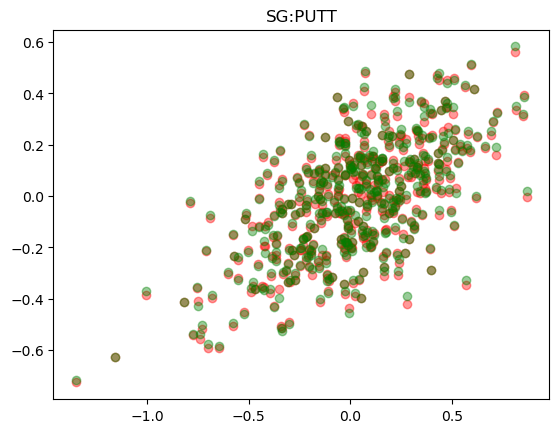

SVR score:  0.5465426103870823
Lin score:  0.5458877780853151
threshold:  0.1689905033036552
% obs w/in one threshold of mean 0.4009546539379475
SVR predictions off by at most one threshold 0.5369928400954654
SVR predictions off by at most one threshold 0.5346062052505967


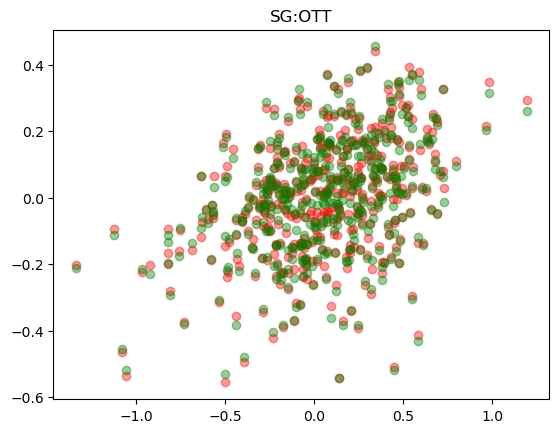

SVR score:  0.7642664235779398
Lin score:  0.7687853300780554
threshold:  0.183492062350291
% obs w/in one threshold of mean 0.36992840095465396
SVR predictions off by at most one threshold 0.7040572792362768
SVR predictions off by at most one threshold 0.7183770883054893


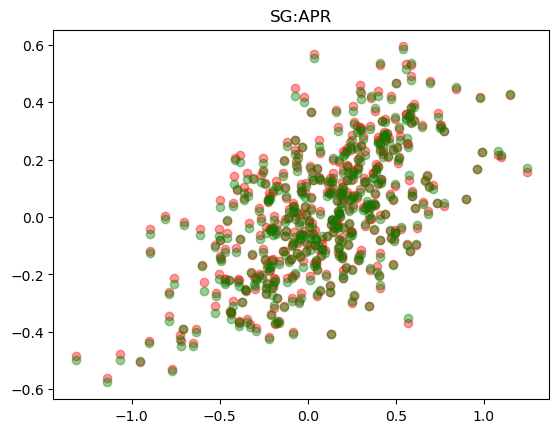

SVR score:  0.6845426361313949
Lin score:  0.685696639692021
threshold:  0.195789358192779
% obs w/in one threshold of mean 0.35083532219570407
SVR predictions off by at most one threshold 0.6014319809069213
SVR predictions off by at most one threshold 0.60381861575179


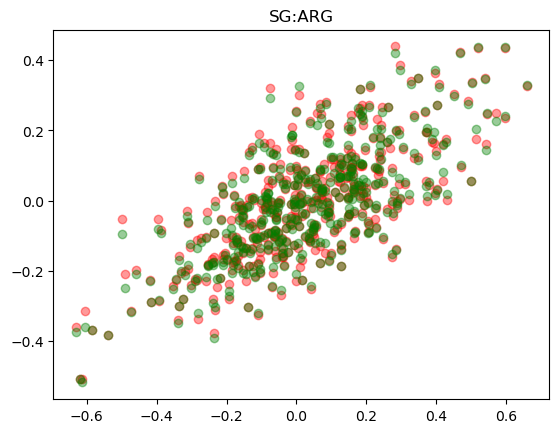

SVR score:  0.47973300344103087
Lin score:  0.4831270470285114
threshold:  0.11133465983151448
% obs w/in one threshold of mean 0.39856801909307876
SVR predictions off by at most one threshold 0.5369928400954654
SVR predictions off by at most one threshold 0.5393794749403341


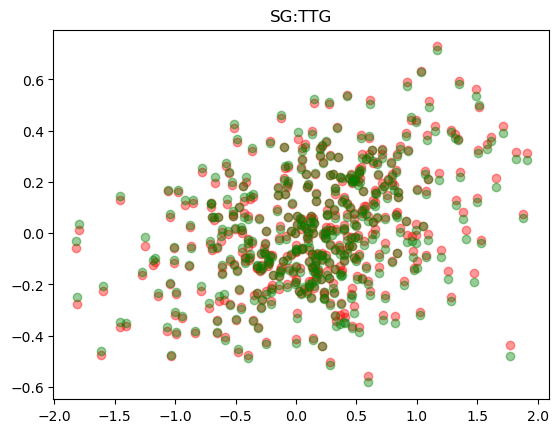

SVR score:  0.8810774037983129
Lin score:  0.8810177059400719
threshold:  0.33014348062031096
% obs w/in one threshold of mean 0.38902147971360385
SVR predictions off by at most one threshold 0.847255369928401
SVR predictions off by at most one threshold 0.8424821002386634


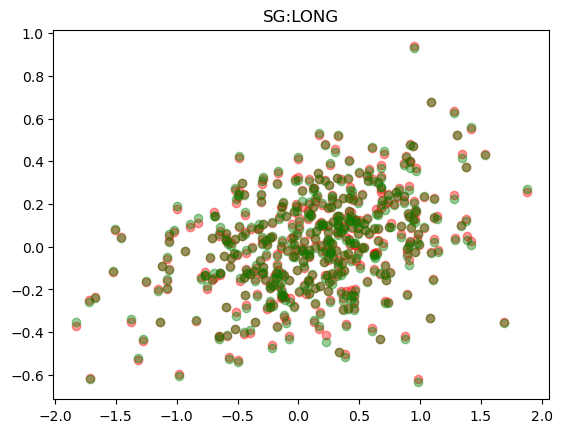

SVR score:  0.8600838966865236
Lin score:  0.8596636069912553
threshold:  0.31030478722694094
% obs w/in one threshold of mean 0.36992840095465396
SVR predictions off by at most one threshold 0.8186157517899761
SVR predictions off by at most one threshold 0.8257756563245824


In [191]:
def svr_lin_regs(X,y):
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=.25,random_state=62)
    scaler=StandardScaler()
    X_train_scaled=scaler.fit_transform(X_train)
    X_test_scaled=scaler.transform(X_test)
    svr=SVR(kernel='linear',C=.6,epsilon=.2)
    lin=LinearRegression()
    svr.fit(X_train_scaled,y_train)
    lin.fit(X_train_scaled,y_train)
    y_pred_svr=svr.predict(X_test_scaled)
    y_pred_lin=lin.predict(X_test_scaled)
    residuals_svr=(y_test-y_pred_svr)
    residuals_lin=(y_test-y_pred_lin)
    plt.scatter(x=y_test,y=residuals_svr,color='red',alpha=.4)
    plt.scatter(x=y_test,y=residuals_lin,color='green',alpha=.4)
    plt.show()
    print('SVR score: ',svr.score(X_test_scaled,y_test))
    print('Lin score: ',lin.score(X_test_scaled,y_test))
    threshold=y_test.std()/2
    print('threshold: ',threshold)
    print('% obs w/in one threshold of mean', (abs(y_test)<threshold).sum()/len(residuals_svr))
    print('SVR predictions off by at most one threshold',(abs(residuals_svr)<threshold).sum()/len(residuals_svr))
    print('SVR predictions off by at most one threshold',(abs(residuals_lin)<threshold).sum()/len(residuals_lin))
    
for i in range(len(yvars)):
    target=yvars[i] 
    plt.title(target)
    svr_lin_regs(pga.drop(nonvars+yvars,axis=1).values,pga[target].values)

## Conclusion for Part 1

The SVR and linear regressions perform almost identically, and that probably has a lot to do with my setting of the parameters for the SVR to optimize R^2 as opposed to minimizing the number of residuals outside some epsilon-tube. 
The big takeaways are that off the tee performance and overall long game performance are well-predicted by the basic features we've used here, with R^2 values around .75 and .85, respectively, and guessing something like 80% of observations within one standard deviation (as opposed to just 40% of the overall population falling within one standard deviation). In part 2, I add more features to flesh things out and see if we can improve our predictions. 